In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def flatten_img(img):
    return np.reshape(img, (img.shape[0]*img.shape[1], 1))

In [3]:
def unflatten_img(flat_img):
    img_width = int(math.sqrt(flat_img.size))
    return np.reshape(flat_img, (img_width, img_width,))

Load images

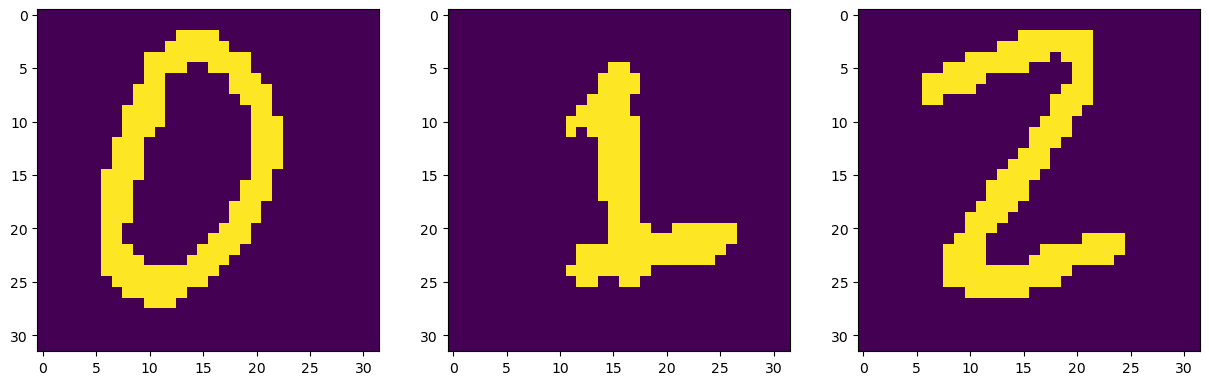

In [4]:
img_paths = ['p0.csv', 'p1.csv', 'p2.csv']
np_imgs = []

plt.figure(figsize=(15,9))
for i, pth in enumerate(img_paths):
    img = unflatten_img(np.genfromtxt(pth))
    img = np.swapaxes(img, 0, 1)
    np_imgs.append(img)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
plt.show()

Distort function

In [5]:
def distort_image(img, prop=0.05):
    if prop<0 or prop>1:
        print('Out-of-bound proportion: going to default 0.05')
        prop = 0.05; # Default proportion
    
    num_pixels_to_change = round(img.size*prop)
    
    # Generate an array of ones and insert -1s at the start equal to the num of pixel to change
    # then shuffle and reshape to get the mask
    distortion_arr = np.ones(img.size)
    distortion_arr[:num_pixels_to_change] = -1
    distortion_mask = np.reshape(np.random.permutation(distortion_arr), img.shape)

    distorted_img = np.multiply(img, distortion_mask)

    return distorted_img

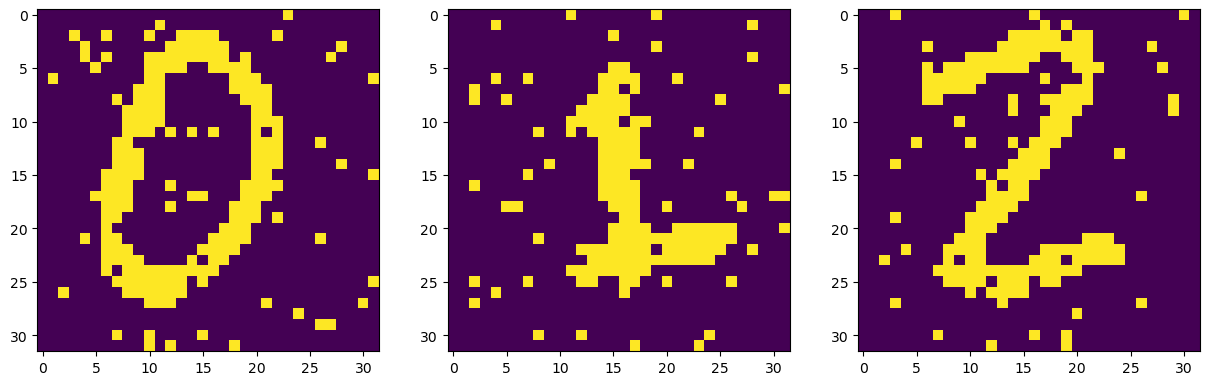

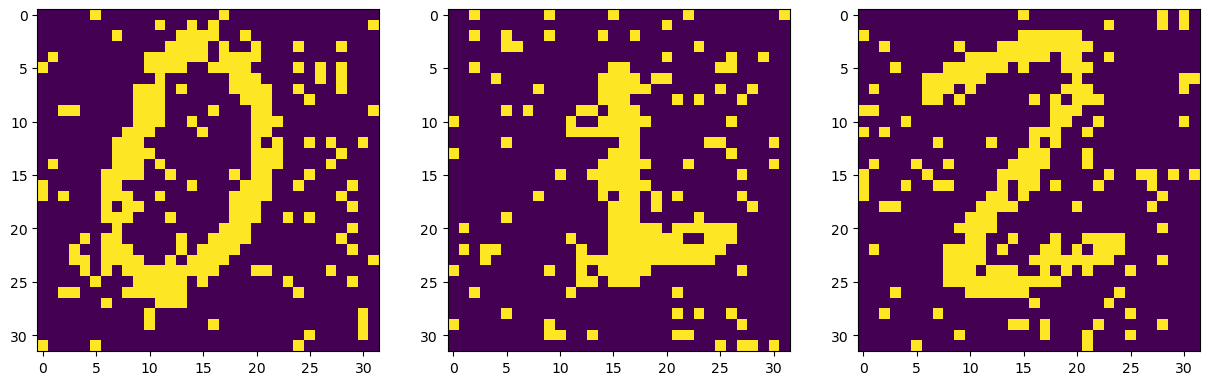

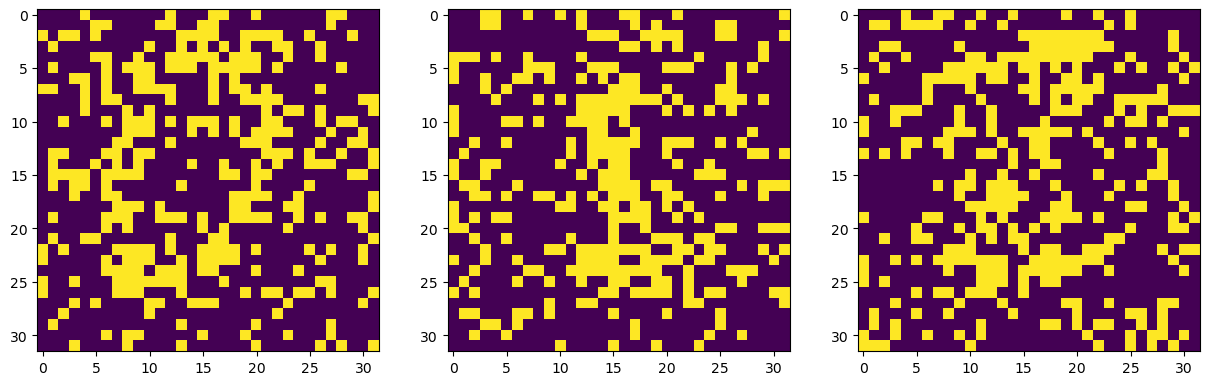

In [6]:
distorted_imgs = []
dist_prop_list = [0.05, 0.1, 0.25]

for dist_prop in dist_prop_list:
    plt.figure(figsize=(15,9))
    for i, img in enumerate(np_imgs):
        distorted_img = distort_image(img, dist_prop)
        distorted_imgs.append(distorted_img)

        plt.subplot(1, 3, i+1)
        plt.imshow(distorted_img)
    plt.show()

# Hopfield model

In [7]:
def storage_phase(X):
    # Flatten inputs
    flat_X = []
    for x in X:
        flat_X.append(flatten_img(x))

    # Convert to numpy array, rows are patterns and columns are features
    patterns = np.array(flat_X).reshape(len(flat_X), flat_X[0].shape[0])

    num_patterns = patterns.shape[0]
    num_neurons = patterns.shape[1]

    # Calulate weights following Hopfield model rule 
    weights = (np.matmul(patterns.T, patterns) - num_patterns * np.eye(num_neurons)) / num_neurons

    plt.imshow(weights)
    plt.title('Weigthts matrix')
    plt.show()

    return weights

In [8]:
# Return set of num_biases random biases
def init_bias(X, num_biases):
    # Flatten inputs
    flat_X = []
    for x in X:
        flat_X.append(flatten_img(x))

    # Convert to numpy array, rows are patterns and columns are features
    patterns = np.array(flat_X).reshape(len(flat_X), flat_X[0].shape[0])

    num_neurons = patterns.shape[1]

    rand_bias_set = np.random.rand(num_neurons, num_biases)

    return rand_bias_set

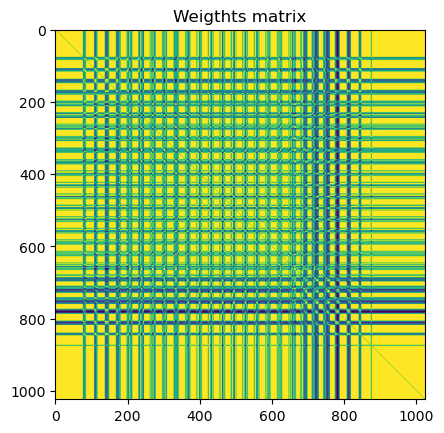

In [9]:
initial_w = storage_phase(np_imgs)
bias_set = init_bias(np_imgs, num_biases=1)

In [10]:
def create_overlap_fuctions(patterns):
    # Flatten inputs
    flat_pats = []
    for pattern in patterns:
        flat_pats.append(flatten_img(pattern))
    # Convert to numpy array, rows are patterns and columns are features
    #patterns = np.array(flat_pats).reshape(len(flat_pats), flat_pats[0].shape[0])

    # Create overlap function for each pattern
    overlap_functions = []
    for flat_pat in flat_pats:
        # Overlap function for each pattern
        overlap_func = lambda x, pattern=flat_pat: np.average(pattern * x)
        overlap_functions.append(overlap_func)
    
    return overlap_functions

In [11]:
def energy_function(x, w, bias):
    energy = np.dot(np.dot(np.transpose(x), w), x) + np.dot(np.transpose(x), bias)
    return energy.item()

In [12]:
# Discrepancy is defined as the ratio of different pixels
def discrepancy_function(x, pattern):
    return np.sum(np.abs(x - pattern)) / len(x)

In [13]:
def retrieve_sample(flat_x, original_x, w, bias, num_epochs, num_neurons, overlap_funcs, print_state=False):
    rec_x = flat_x.copy()
    energy_list = []
    discrepancy_list = []
    overlap_list = []
    for f in overlap_funcs:
        overlap_list.append([])

    for epoch in range(num_epochs):
        neurons_order = np.random.permutation(range(num_neurons))
   
        for i, index in enumerate(neurons_order):
            # Calculate state
            rec_x[index, :] = np.sign(np.dot(w[index,:], rec_x) + bias[index])
            # Calculate energy
            energy_list.append(energy_function(rec_x, w, bias))
            # Calculate discrepancy
            discrepancy_list.append(discrepancy_function(rec_x, original_x))
            # Calculate overlaps
            for j, f in enumerate(overlap_funcs):
                overlap_list[j].append(f(rec_x))

            if print_state and i % 100 == 0:
                plt.imshow(unflatten_img(rec_x))
                plt.show()

    return energy_list, overlap_list, discrepancy_list, rec_x

In [14]:
def retrieval_phase(X, original_X, w, bias_set, num_epochs, overlap_funcs, distort_list):
     # Flatten inputs
    flat_X = []
    for x in X:
        flat_X.append(flatten_img(x))
    original_flat_X = []
    for x in original_X:
        original_flat_X.append(flatten_img(x))

    num_neurons = flat_X[0].shape[0]

    for j, flat_x in enumerate(flat_X):
        # Get the undistorted image for comparison
        original_index = j % len(original_X)
        distort_index = j // len(original_X)
        original_flat_x = original_flat_X[original_index]

        for i in range(bias_set.shape[1]):
            bias = bias_set[:, i]
            energy_list, overlap_list, discrepancy_list, rec_x = retrieve_sample(flat_x, original_flat_x, w, bias, num_epochs, num_neurons, overlap_funcs)
            
            # Plot images
            plt.figure(figsize=(15,8))

            plt.subplot(2,3,1)
            plt.imshow(unflatten_img(flat_x))
            plt.title('Distorted')
            plt.subplot(2,3,2)
            plt.imshow(unflatten_img(original_flat_x))
            plt.title('Original')
            plt.subplot(2,3,3)
            plt.imshow(unflatten_img(rec_x))
            plt.title('Reconstructed')
            
            plt.subplot(2,3,4)
            plt.plot(energy_list)
            plt.title('Energy')

            plt.subplot(2,3,5)
            for i, overlap in enumerate(overlap_list):
                plt.plot(overlap, label=i)
                plt.legend()
            plt.title('Overlaps')

            plt.subplot(2,3,6)
            plt.plot(discrepancy_list)
            plt.title('Discrepancy')

            
            plt.suptitle("Pattern: {} - Distortion: {}".format(original_index, distort_list[distort_index]))
            plt.show()

            # Save plot



            plt.savefig("output/pattern_{}_distort_{}.png".format(original_index, distort_list[distort_index]))

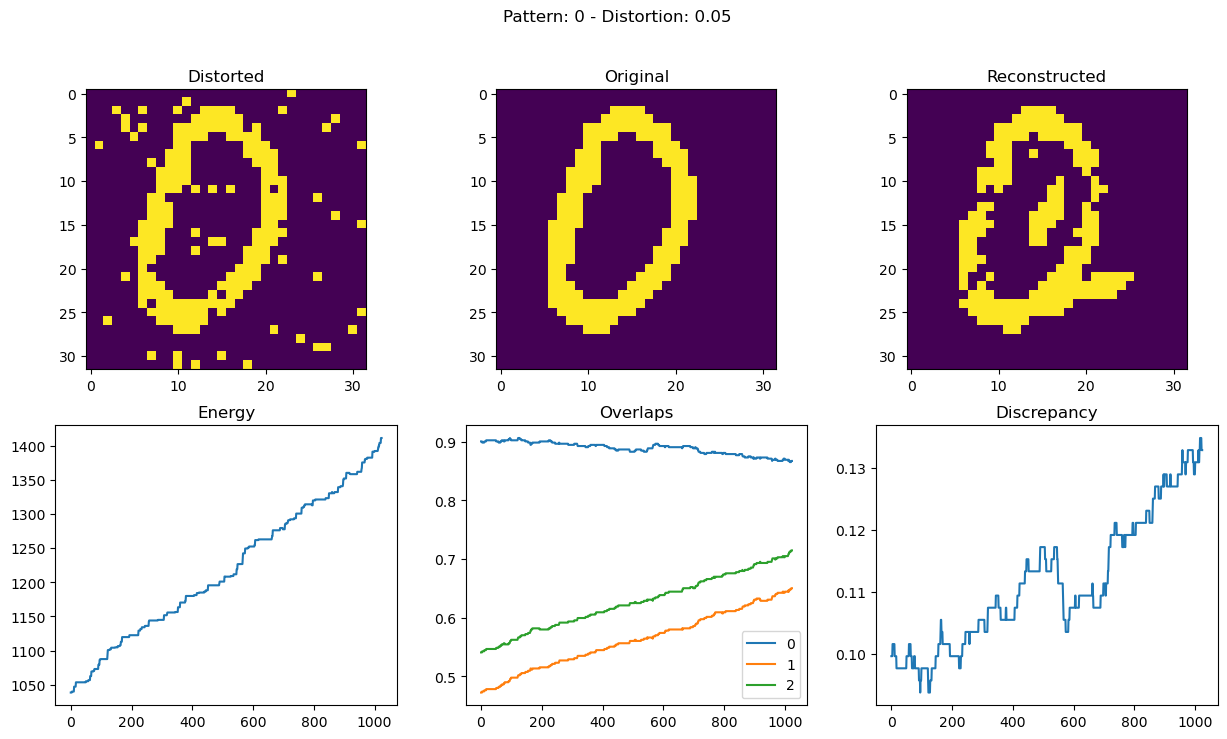

<Figure size 640x480 with 0 Axes>

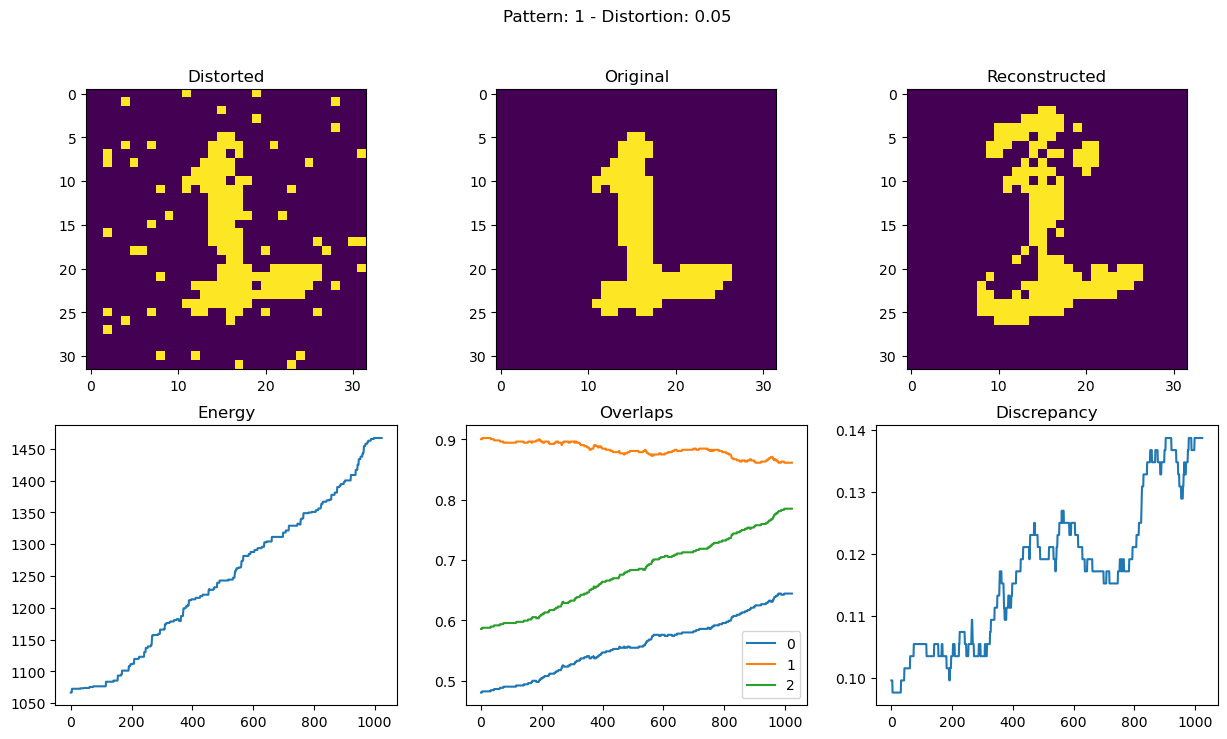

<Figure size 640x480 with 0 Axes>

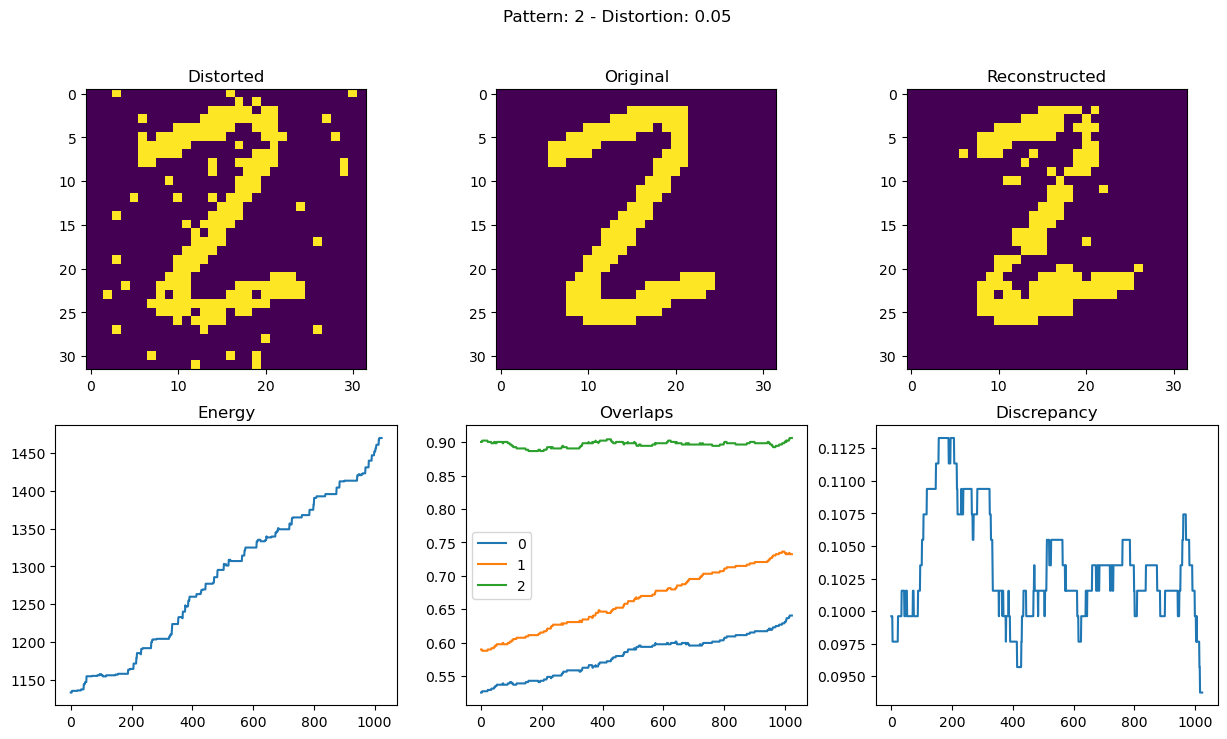

<Figure size 640x480 with 0 Axes>

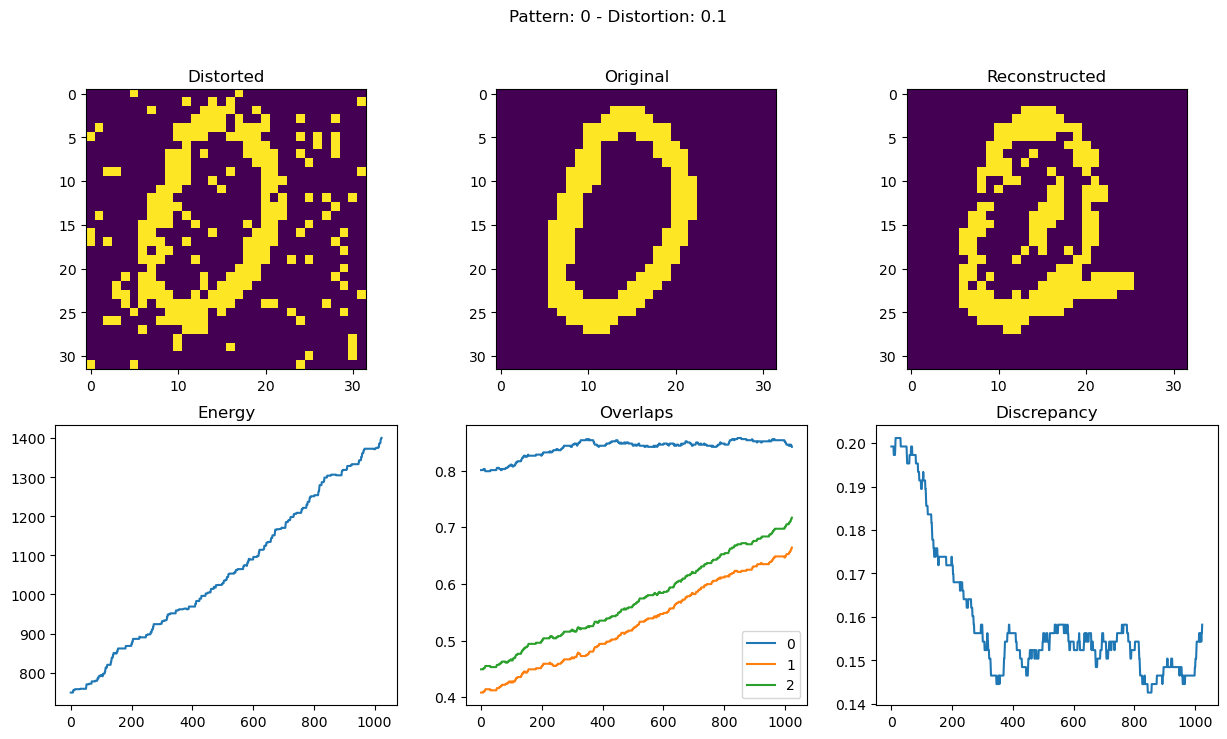

<Figure size 640x480 with 0 Axes>

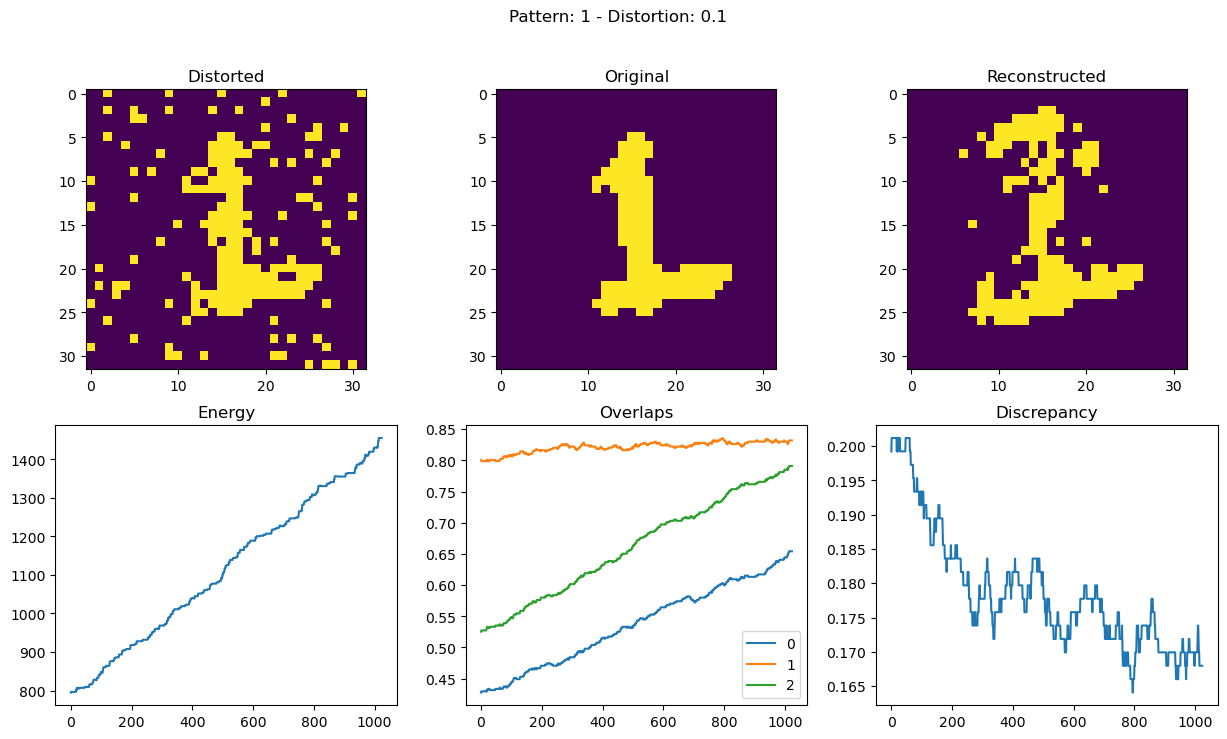

<Figure size 640x480 with 0 Axes>

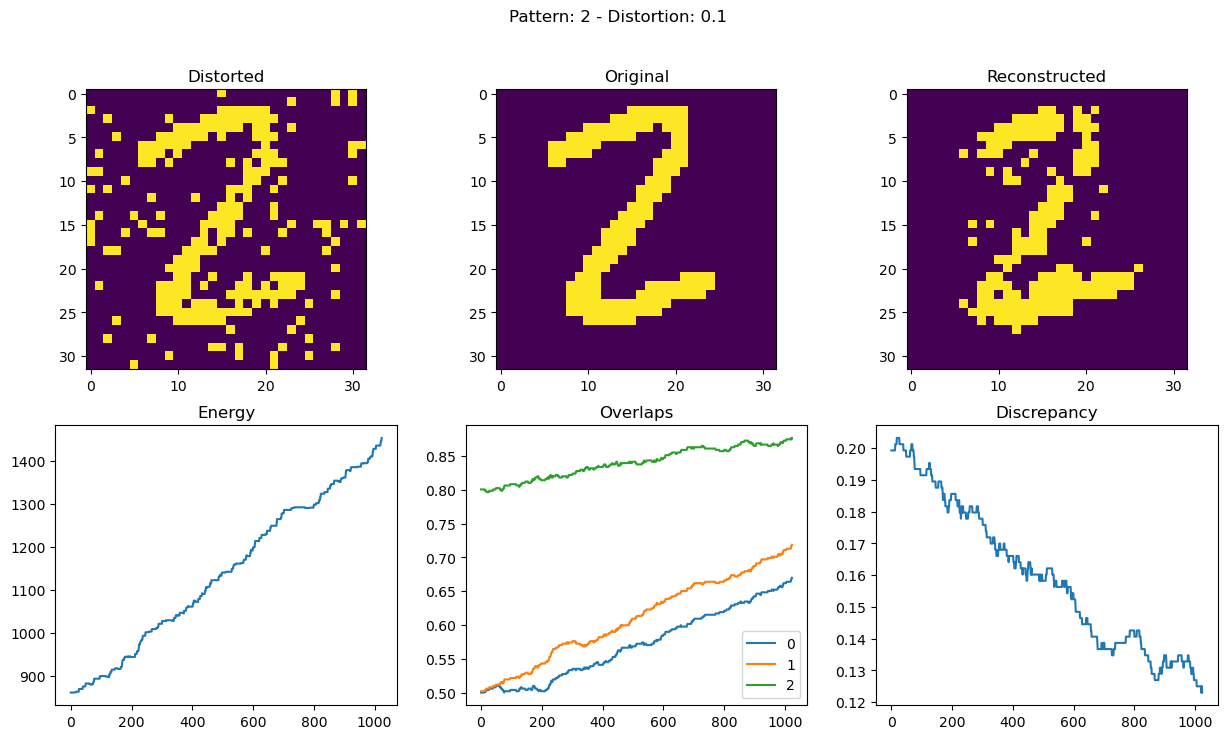

<Figure size 640x480 with 0 Axes>

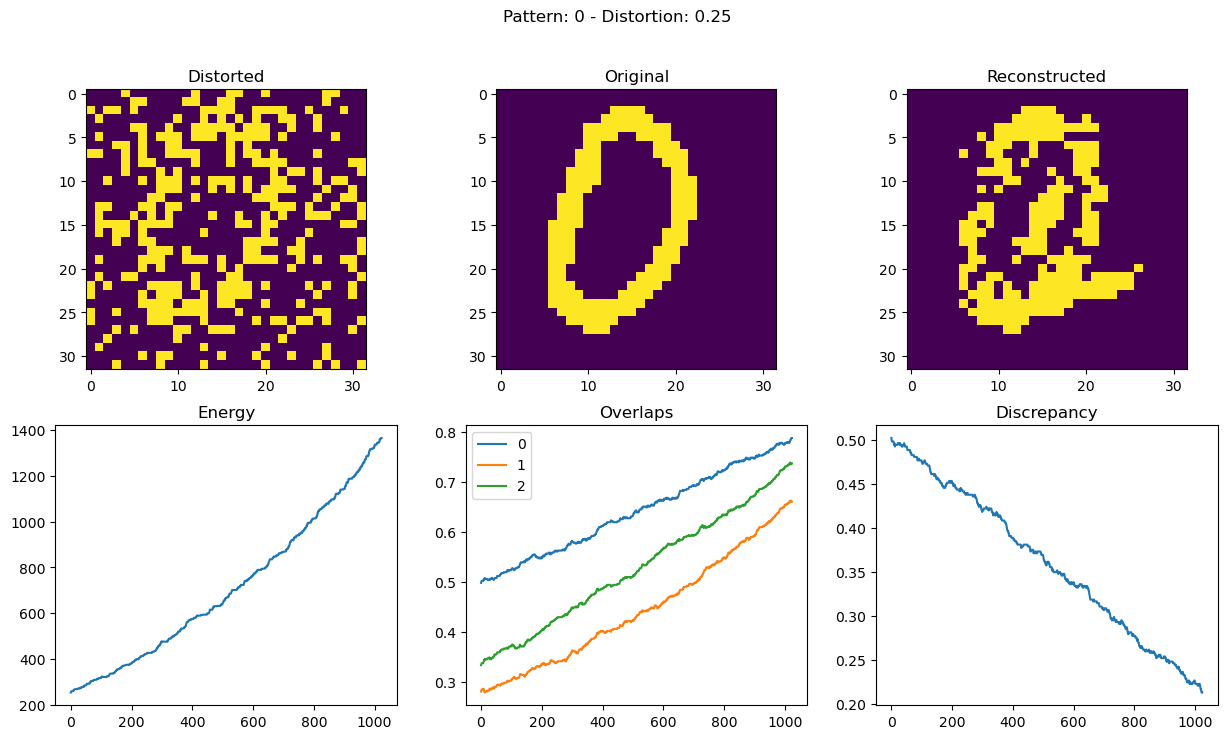

<Figure size 640x480 with 0 Axes>

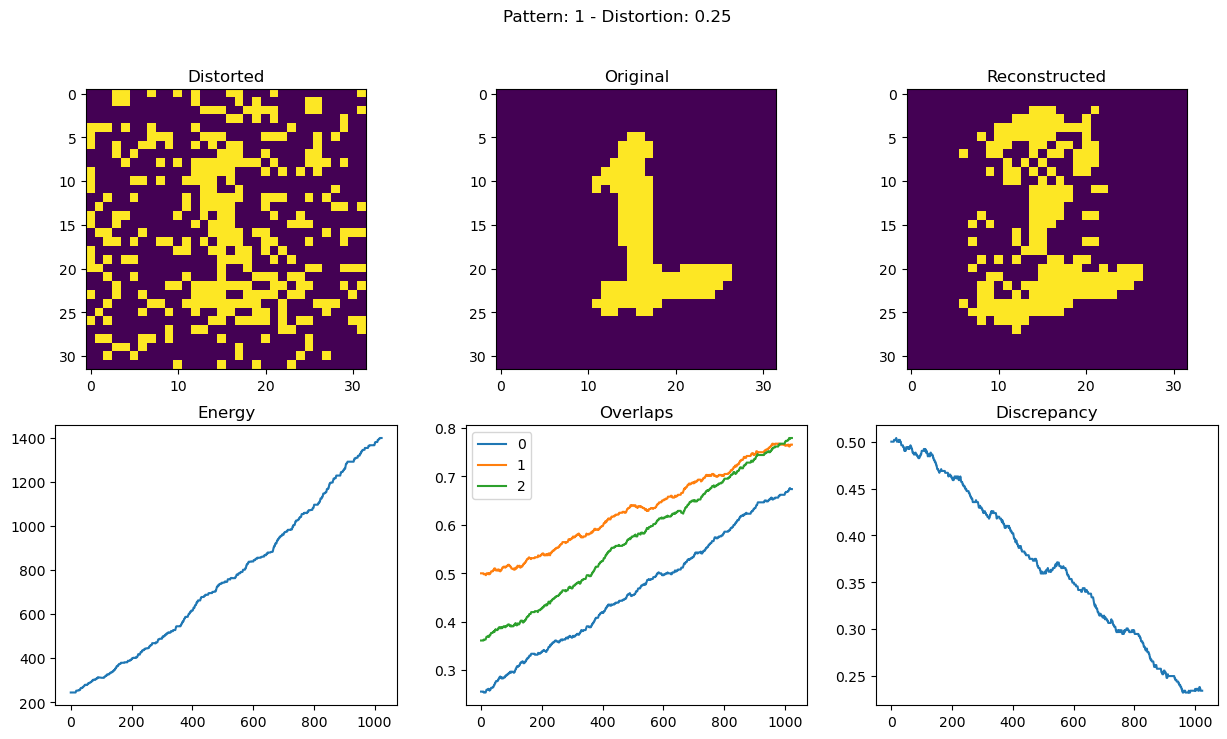

<Figure size 640x480 with 0 Axes>

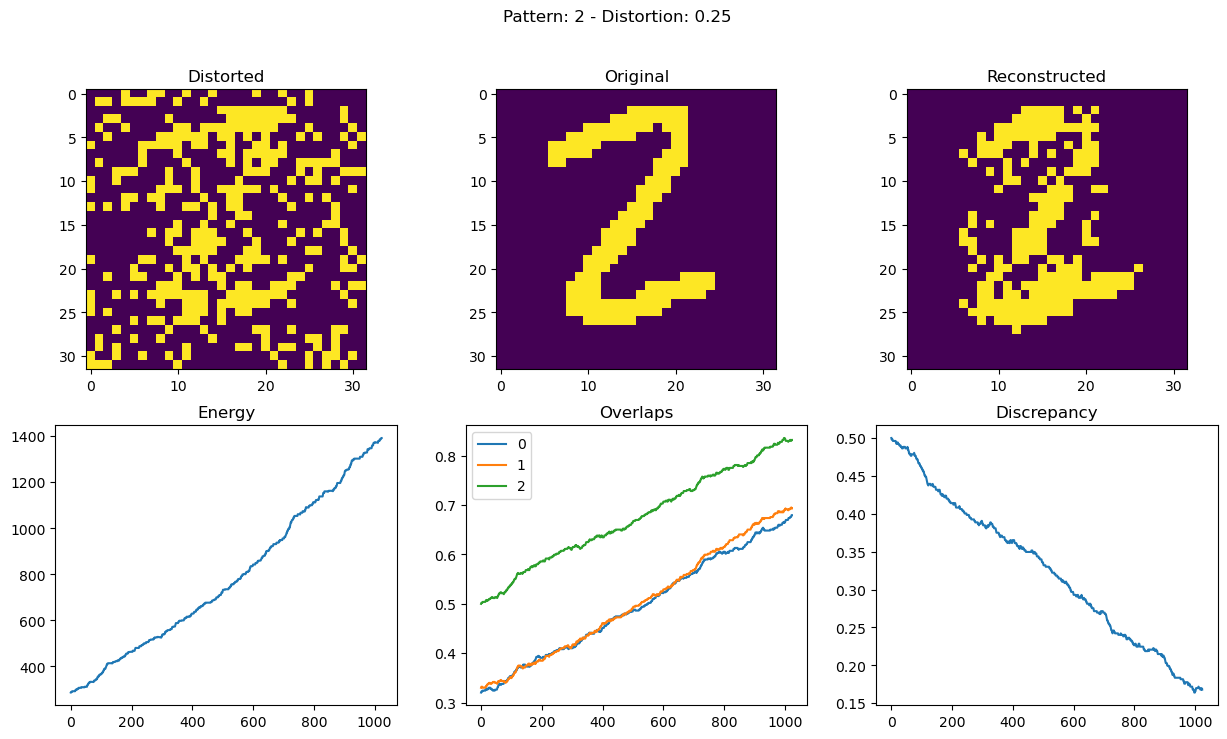

<Figure size 640x480 with 0 Axes>

In [15]:
overlap_funcs = create_overlap_fuctions(np_imgs)
retrieval_phase(X=distorted_imgs, original_X=np_imgs, w=initial_w, bias_set=bias_set, num_epochs=1, overlap_funcs=overlap_funcs, distort_list=dist_prop_list)